Timbre: the character or quality of a musical sound or voice as distinct from its pitch and intensity.
 - what is making the sound? Instruments
 - How is the instrument being player? Plyaing Techniques
 - How are different instruments being combined? Ensambles

# Import Required Python Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.models import load_model
from keras.regularizers import l2
from keras.utils import np_utils

# Import and Exam Dataset

In [2]:
# Create columns

timbre_atts= ["T"+str(i) for i in range(1, 91)]
colnames = ["Year"] + timbre_atts

print(colnames)

['Year', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18', 'T19', 'T20', 'T21', 'T22', 'T23', 'T24', 'T25', 'T26', 'T27', 'T28', 'T29', 'T30', 'T31', 'T32', 'T33', 'T34', 'T35', 'T36', 'T37', 'T38', 'T39', 'T40', 'T41', 'T42', 'T43', 'T44', 'T45', 'T46', 'T47', 'T48', 'T49', 'T50', 'T51', 'T52', 'T53', 'T54', 'T55', 'T56', 'T57', 'T58', 'T59', 'T60', 'T61', 'T62', 'T63', 'T64', 'T65', 'T66', 'T67', 'T68', 'T69', 'T70', 'T71', 'T72', 'T73', 'T74', 'T75', 'T76', 'T77', 'T78', 'T79', 'T80', 'T81', 'T82', 'T83', 'T84', 'T85', 'T86', 'T87', 'T88', 'T89', 'T90']


In [3]:
# Load data set and create dataframe

file_name = "YearPredictionMSD.txt"
df_raw = pd.read_csv(file_name, names= colnames)

df_atts = df_raw[timbre_atts]

In [4]:
df_raw.shape

(38560, 91)

In [5]:
df_raw.describe()

,Year,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19,T20,T21,T22,T23,T24,T25,T26,T27,T28,T29,T30,T31,T32,T33,T34,T35,T36,T37,T38,T39,...,T51,T52,T53,T54,T55,T56,T57,T58,T59,T60,T61,T62,T63,T64,T65,T66,T67,T68,T69,T70,T71,T72,T73,T74,T75,T76,T77,T78,T79,T80,T81,T82,T83,T84,T85,T86,T87,T88,T89,T90
count,38560.000000,38560.000000,38560.000000,38560.000000,38560.000000,38560.000000,38560.000000,38560.000000,38560.000000,38560.000000,38560.000000,38560.000000,38560.000000,38560.000000,38560.000000,38560.000000,38560.000000,38560.000000,38560.000000,38560.000000,38560.000000,38560.000000,38560.000000,38560.000000,38560.000000,38560.000000,38560.000000,38560.000000,38560.000000,38560.000000,38560.000000,38560.000000,38560.000000,38560.000000,38560.000000,38560.000000,38560.000000,38560.000000,38560.000000,38560.000000,...,38560.000000,38560.000000,38560.000000,38560.000000,38560.000000,38560.000000,38560.000000,38560.000000,38560.000000,38560.000000,38560.000000,38560.000000,38560.000000,38560.000000,38560.000000,38560.000000,38560.000000,38559.000000,38559.000000,38559.000000,38559.000000,38559.000000,38559.000000,38559.000000,38559.000000,38559.000000,38559.000000,38559.000000,38559.000000,38559.000000,38559.000000,38559.000000,38559.000000,38559.000000,38559.000000,38559.000000,38559.000000,38559.000000,38559.000000,38559.000000
mean,1998.600908,43.461064,1.855537,8.427547,1.484068,-6.439953,-9.461958,-2.048238,-1.805780,3.817934,1.986552,-0.146144,2.442436,33.516078,2411.892876,1963.243450,1518.232177,907.849919,884.384870,604.275194,516.142191,391.570988,324.437458,290.626816,292.273975,43.153086,52.898308,-51.881719,-25.656492,18.860889,45.187219,5.606603,24.885286,9.445926,-3.732781,-0.084925,71.959792,-46.208695,121.835008,-191.711712,...,6.459042,28.604449,11.572985,1.087659,-10.417676,67.137012,102.972498,-1.801343,37.439185,-29.444787,3.711942,0.241544,-0.289510,-140.474210,0.688090,0.764056,2.803513,27.836784,32.047913,-0.575478,-11.281774,6.347087,-27.270001,-11.892166,-21.847013,-5.648394,-24.981547,31.580586,-105.356988,28.065126,16.017704,-71.655031,40.256255,39.608185,0.402916,17.525826,-22.639214,4.460304,19.473551,1.419440
std,10.505091,5.995238,50.173895,34.788437,16.365352,22.247025,13.015004,14.218294,7.927973,10.379476,6.509164,4.369716,8.171238,22.460657,1727.094868,1243.104882,1106.982838,468.177553,576.450412,312.909376,311.855066,208.720846,165.805652,185.552034,149.807657,120.535263,717.899522,540.633853,219.682703,161.444521,135.867148,100.294902,71.902220,72.237949,52.256576,41.809789,106.382749,421.341102,451.888241,265.877132,...,94.279388,75.120357,71.952848,82.196758,57.781901,276.057196,310.960565,276.534222,164.955474,142.237257,59.916288,49.225824,37.346344,304.772252,225.832621,127.475916,99.884847,116.462056,102.571010,36.268800,256.118784,222.696312,166.913310,62.780533,65.367396,26.691158,265.674090,143.601474,201.712422,123.222723,31.860809,172.349065,121.415127,95.447946,15.934914,112.835065,174.637225,13.377414,187.537539,22.121244
min,1922.000000,4.418500,-284.908360,-257.525600,-120.723150,-126.007560,-61.602380,-165.322690,-55.613470,-119.487530,-34.837320,-31.933580,-61.640130,0.845230,113.131090,95.665290,89.312120,73.193270,27.581730,47.160440,52.773480,36.936930,27.215080,14.766780,28.995130,-2214.380450,-11568.506270,-11286.983620,-2954.933900,-2177.218110,-1194.898830,-1883.486160,-1018.738570,-840.914500,-555.667130,-473.255980,-731.742970,-5977.867140,-6701.728750,-9752.741090,...,-1368.351350,-862.513640,-2525.455790,-1624.942210,-1033.491090,-3057.756540,-3494.016920,-4730.599100,-1557.195530,-1393.256190,-727.147490,-644.631600,-471.673860,-5118.655690,-4951.905530,-1443.825390,-842.269260,-1568.341360,-1101.666570,-521.253730,-7057.712450,-3077.026190,-5210.019120,-543.819950,-994.568200,-396.272080,-3032.446100,-1813.568020,-6033.497910,-1990.446430,-424.517570,-2334.760570,-1256.181470,-1412.660510,-177.593500,-2343.894110,-2605.505090,-233.456480,-2862.

In [6]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38560 entries, 0 to 38559
Data columns (total 91 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    38560 non-null  int64  
 1   T1      38560 non-null  float64
 2   T2      38560 non-null  float64
 3   T3      38560 non-null  float64
 4   T4      38560 non-null  float64
 5   T5      38560 non-null  float64
 6   T6      38560 non-null  float64
 7   T7      38560 non-null  float64
 8   T8      38560 non-null  float64
 9   T9      38560 non-null  float64
 10  T10     38560 non-null  float64
 11  T11     38560 non-null  float64
 12  T12     38560 non-null  float64
 13  T13     38560 non-null  float64
 14  T14     38560 non-null  float64
 15  T15     38560 non-null  float64
 16  T16     38560 non-null  float64
 17  T17     38560 non-null  float64
 18  T18     38560 non-null  float64
 19  T19     38560 non-null  float64
 20  T20     38560 non-null  float64
 21  T21     38560 non-null  float64
 22

### Data visualization

In [7]:
# Check number of columns
print(df_raw.shape[1])      

91


In [8]:
# count number of songs for each year

year_cnt = df_raw['Year'].value_counts().to_dict()
# for year, cnt in year_cnt.items():
#     print(f"{year} : {cnt}")

year_range = df_raw['Year'].max() - df_raw['Year'].min() + 1
print(year_range)

89


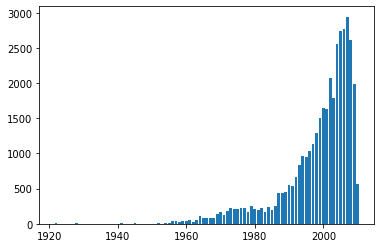

In [9]:
# Plot Bar graph

year_cnt_lst = sorted(year_cnt.items()) 
x, y = zip(*year_cnt_lst) 

plt.bar(x, y, align='center')
plt.show()

### Dataset preparation
Since PCA is an unsupervised approach (the analysis does not depend on the labels or categories or response to predict), we don't need non-numerical data.

In [10]:
# all data are numerical, so just take them all 
df = df_atts.iloc[:,:]

## Principal Component Analysis
The analysis consists of five main steps:
1. Correlation matrix: computing the covariance of standardized data matrix
2. Factoring the correlation matrix into eigenvalues and eigenvectors
3. Scree plot. It is a plot of eigenvalue order number vs proportion of variance explained by the eigenvalue. It is a useful visual way to to determine how many components should be selected. To determine the number of compnents we look for an bend in the scree plot.
    - In multivariate statistics, a scree plot is a line plot of the eigenvalues of factors or principal components in an analysis.[1] The scree plot is used to determine the number of factors to retain in an exploratory factor analysis (FA) or principal components to keep in a principal component analysis (PCA).
4. Computing the principal components  

### Correlation Matrix (or Covariance matrix of Standardized Data)

In [11]:
""" 
“Covariance” indicates the direction of the linear relationship between variables. 
“Correlation” on the other hand measures both the strength and direction of the linear relationship between two variables
"""

df_corr = df.corr()
df_corr

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19,T20,T21,T22,T23,T24,T25,T26,T27,T28,T29,T30,T31,T32,T33,T34,T35,T36,T37,T38,T39,T40,...,T51,T52,T53,T54,T55,T56,T57,T58,T59,T60,T61,T62,T63,T64,T65,T66,T67,T68,T69,T70,T71,T72,T73,T74,T75,T76,T77,T78,T79,T80,T81,T82,T83,T84,T85,T86,T87,T88,T89,T90
T1,1.000000,0.570138,0.256880,0.005799,-0.259615,-0.277909,0.168491,-0.041759,0.199465,0.117506,0.057409,-0.126355,-0.381056,-0.457150,-0.452832,-0.376489,-0.400396,-0.299013,-0.442599,-0.319324,-0.484307,-0.299371,-0.265283,-0.435982,0.097290,-0.159048,-0.147973,0.071798,0.135283,-0.049818,-0.137449,0.092101,-0.088027,-0.055710,-0.033454,-0.382596,-0.191789,0.006396,0.007216,-0.122730,...,-0.080395,-0.091627,0.080164,-0.036689,0.216670,-0.274791,-0.142465,-0.105209,-0.138577,-0.111258,-0.030057,0.113202,-0.512128,0.107403,0.017212,-0.052609,-0.105332,0.036270,-0.101481,0.133323,0.298054,-0.038340,0.073890,0.016374,0.048398,0.251129,-0.231731,-0.021260,0.145434,0.038188,-0.375255,0.188928,-0.150594,-0.001650,0.118844,-0.040102,0.023176,-0.155474,-0.112465,-0.191013
T2,0.570138,1.000000,0.012158,0.093163,-0.148557,-0.122707,0.111687,0.109817,0.106520,0.361498,-0.093311,-0.055098,-0.172273,-0.295200,-0.176118,-0.119417,-0.195707,-0.038277,-0.193052,-0.096697,-0.330867,-0.079489,-0.011891,-0.286379,-0.102335,-0.061116,-0.170649,0.150555,0.263372,0.031992,-0.153346,0.185740,-0.107596,0.019062,-0.117908,-0.313913,-0.079686,0.223275,-0.069957,-0.165275,...,-0.140982,0.015238,0.138678,-0.104820,0.179313,-0.194412,-0.064039,0.070248,-0.042481,0.036075,-0.009773,0.081294,-0.350603,0.130907,-0.087586,-0.062307,-0.067975,0.081834,-0.099171,0.103839,0.208355,-0.123859,0.004879,0.046522,-0.015320,0.281235,-0.276575,-0.074650,0.080400,0.044829,-0.298987,0.056178,-0.166733,0.000847,0.146936,0.029949,-0.031217,-0.026652,-0.130498,-0.177306
T3,0.256880,0.012158,1.000000,0.142593,-0.140388,0.045362,-0.050036,0.081658,0.047763,-0.094010,0.038927,-0.028118,-0.081290,-0.243934,-0.201833,-0.284641,-0.139402,-0.379216,-0.140599,-0.368090,-0.068707,-0.350248,-0.294641,-0.029308,-0.056925,0.043517,0.179026,0.120713,-0.126819,-0.269317,0.100605,-0.122727,0.211798,-0.085585,0.217074,-0.174522,0.010390,-0.067080,-0.025955,0.044242,...,-0.148721,0.130356,-0.148576,0.082296,-0.121329,-0.213263,-0.064990,0.042667,-0.120234,0.152825,-0.061205,0.078878,-0.158677,0.136893,-0.031602,0.171841,0.104210,-0.211628,0.043259,-0.025205,0.060219,0.187912,-0.216362,-0.080795,0.185959,0.000284,-0.047057,0.057954,-0.100040,0.001780,0.065536,0.168977,0.118455,-0.017799,-0.039046,-0.102393,0.089687,-0.063115,-0.092798,0.080439
T4,0.005799,0.093163,0.142593,1.000000,0.045744,0.335189,0.279249,0.022296,-0.030953,0.165137,0.312317,-0.106089,-0.027536,0.152788,0.276101,0.357584,0.151282,0.531136,0.165230,0.308609,0.025527,0.308932,0.439364,0.050647,-0.029389,0.105648,-0.354020,-0.009929,0.359853,0.327089,-0.086614,0.107647,-0.168416,0.309200,-0.283909,-0.094384,0.115006,0.175063,-0.058512,-0.201736,...,0.165313,-0.046135,0.039822,-0.181464,-0.080291,0.153667,-0.045555,0.043201,-0.051558,-0.064482,0.149108,-0.051958,-0.028463,0.007089,-0.177794,-0.105727,-0.174509,0.409576,-0.148232,0.082122,-0.002535,-0.116854,0.093953,0.129485,-0.210805,-0.125951,0.007807,-0.261165,0.022128,-0.070868,-0.014093,-0.104380,0.036621,0.061579,-0.092184,0.044937,0.027703,0.267033,0.036970,0.000676
T5,-0.259615,-0.148557,-0.140388,0.045744,1.000000,0.026463,-0.100096,-0.012505,-0.207981,-0.097517,0.026117,0.040966,0.149122,0.210655,0.248037,0.229399,0.203831,0.178396,0.321677,0.233193,0.225067,0.251737,0.192798,0.280940,-0.058960,0.020097,0.084989,-0.004138,-0.000952,-0.011965,0.066809,0.051099,-0.001691,0.029595,-0.004179,0.069884,0.049845,0.171358,-0.043960,-0.001699,...,-0.067985,0.095452,0.032197,-0.022216,-0.091385,0.134156,0.075731,0.051083,0.132691,0.032146,0.048361,-0.042203,0.143840,-0.089388,0.023745,-0.026972,-0.008912,0.034190,0.050181,0.064016,-0.067957,-0.088947,0.002657,0.082

In [12]:
w_, v_ = np.linalg.eig(df_corr)

# print(f"Eigenvalues: \n{w_}")
# print(f"Eigenvectors: \n{v_}")

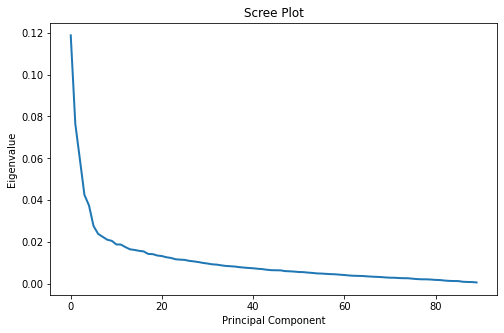

In [13]:
#Determing the number of principal components
"""
Hanbo side notes:
To deal with a not-so-ideal scree plot curve, there are a couple ways:
    Kaiser rule: pick PCs with eigenvalues of at least 1.
    Proportion of variance plot: the selected PCs should be able to describe at least 80% of the variance.
""" 

unsorted_PVE_ = w_/w_.sum()
PVE_ = sorted(unsorted_PVE_, reverse = True)
# print("PVE_ : \n", PVE_)
# print("np.cumsum(PVE_)")
np.cumsum(PVE_)

fig = plt.figure(figsize=(8,5))

plt.plot(PVE_, linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.show()

In [14]:
eigenval_sum = w_.sum()
eigenval_1 = w_[0].sum()
eigenvals_2 = w_[:10].sum()
eigenvals_3 = w_[:20].sum()
eigenvals_4 = w_[:30].sum()
eigenvals_5 = w_[:40].sum()
eigenvals_6 = w_[:50].sum()
eigenvals_7 = w_[:60].sum()
eigenvals_8 = w_[:70].sum()
eigenvals_9 = w_[:80].sum()
eigenvals_10 = w_[:91].sum()


print(f"first  1 eigenvalue : {np.round(100*eigenval_1/eigenval_sum, 2)}%")
print(f"first 10 eigenvalues: {np.round(100*eigenvals_2/eigenval_sum, 2)}%")
print(f"first 20 eigenvalues: {np.round(100*eigenvals_3/eigenval_sum, 2)}%")
print(f"first 30 eigenvalues: {np.round(100*eigenvals_4/eigenval_sum, 2)}%")
print(f"first 40 eigenvalues: {np.round(100*eigenvals_5/eigenval_sum, 2)}%")
print(f"first 50 eigenvalues: {np.round(100*eigenvals_6/eigenval_sum, 2)}%")
print(f"first 60 eigenvalues: {np.round(100*eigenvals_7/eigenval_sum, 2)}%")
print(f"first 70 eigenvalues: {np.round(100*eigenvals_8/eigenval_sum, 2)}%")
print(f"first 80 eigenvalues: {np.round(100*eigenvals_9/eigenval_sum, 2)}%")
print(f"all   90 eigenvalues: {np.round(100*eigenvals_10/eigenval_sum, 2)}%")

first  1 eigenvalue : 11.88%
first 10 eigenvalues: 45.05%
first 20 eigenvalues: 61.13%
first 30 eigenvalues: 72.63%
first 40 eigenvalues: 78.34%
first 50 eigenvalues: 83.5%
first 60 eigenvalues: 86.97%
first 70 eigenvalues: 91.97%
first 80 eigenvalues: 96.11%
all   90 eigenvalues: 100.0%


## Choose attributes based on PCA result above

In [15]:
# map df column names to values
pca_i_dict = dict()
for (i, v), tim_i in zip(enumerate(unsorted_PVE_, start=1), timbre_atts):
    pca_i_dict[tim_i] = v 

#sort dictionary based on values
sorted_tuples = sorted(pca_i_dict.items(), key=lambda item: item[1], reverse = True)
sorted_pca_i_dict = {k: v for k, v in sorted_tuples}
sorted_pca_i_keys = [i for i in sorted_pca_i_dict.keys()]
print(f"Orders of components based on PCA:\n {sorted_pca_i_keys}")

Orders of components based on PCA:
 ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18', 'T19', 'T20', 'T21', 'T22', 'T23', 'T24', 'T25', 'T26', 'T27', 'T28', 'T29', 'T30', 'T31', 'T32', 'T37', 'T38', 'T40', 'T39', 'T41', 'T42', 'T44', 'T45', 'T46', 'T50', 'T51', 'T52', 'T56', 'T62', 'T61', 'T63', 'T64', 'T66', 'T67', 'T68', 'T71', 'T74', 'T89', 'T76', 'T77', 'T79', 'T85', 'T78', 'T87', 'T86', 'T88', 'T84', 'T83', 'T81', 'T82', 'T80', 'T75', 'T90', 'T73', 'T72', 'T70', 'T69', 'T65', 'T60', 'T59', 'T58', 'T57', 'T55', 'T54', 'T53', 'T49', 'T48', 'T47', 'T43', 'T34', 'T35', 'T36', 'T33']


In [16]:
# choose numbers of attributes (columns)

cols_range = 50
cols_lst = ["Year"] + sorted_pca_i_keys[:cols_range]
print(cols_lst)

['Year', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18', 'T19', 'T20', 'T21', 'T22', 'T23', 'T24', 'T25', 'T26', 'T27', 'T28', 'T29', 'T30', 'T31', 'T32', 'T37', 'T38', 'T40', 'T39', 'T41', 'T42', 'T44', 'T45', 'T46', 'T50', 'T51', 'T52', 'T56', 'T62', 'T61', 'T63', 'T64', 'T66']


In [17]:
# Update df with selected cloumns
df_sel = df_raw[cols_lst]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f624b6cd810>,
        ...,
        ...,
        ...,
       ...,
        ...,
        ...,
        ...,
      dtype=object)

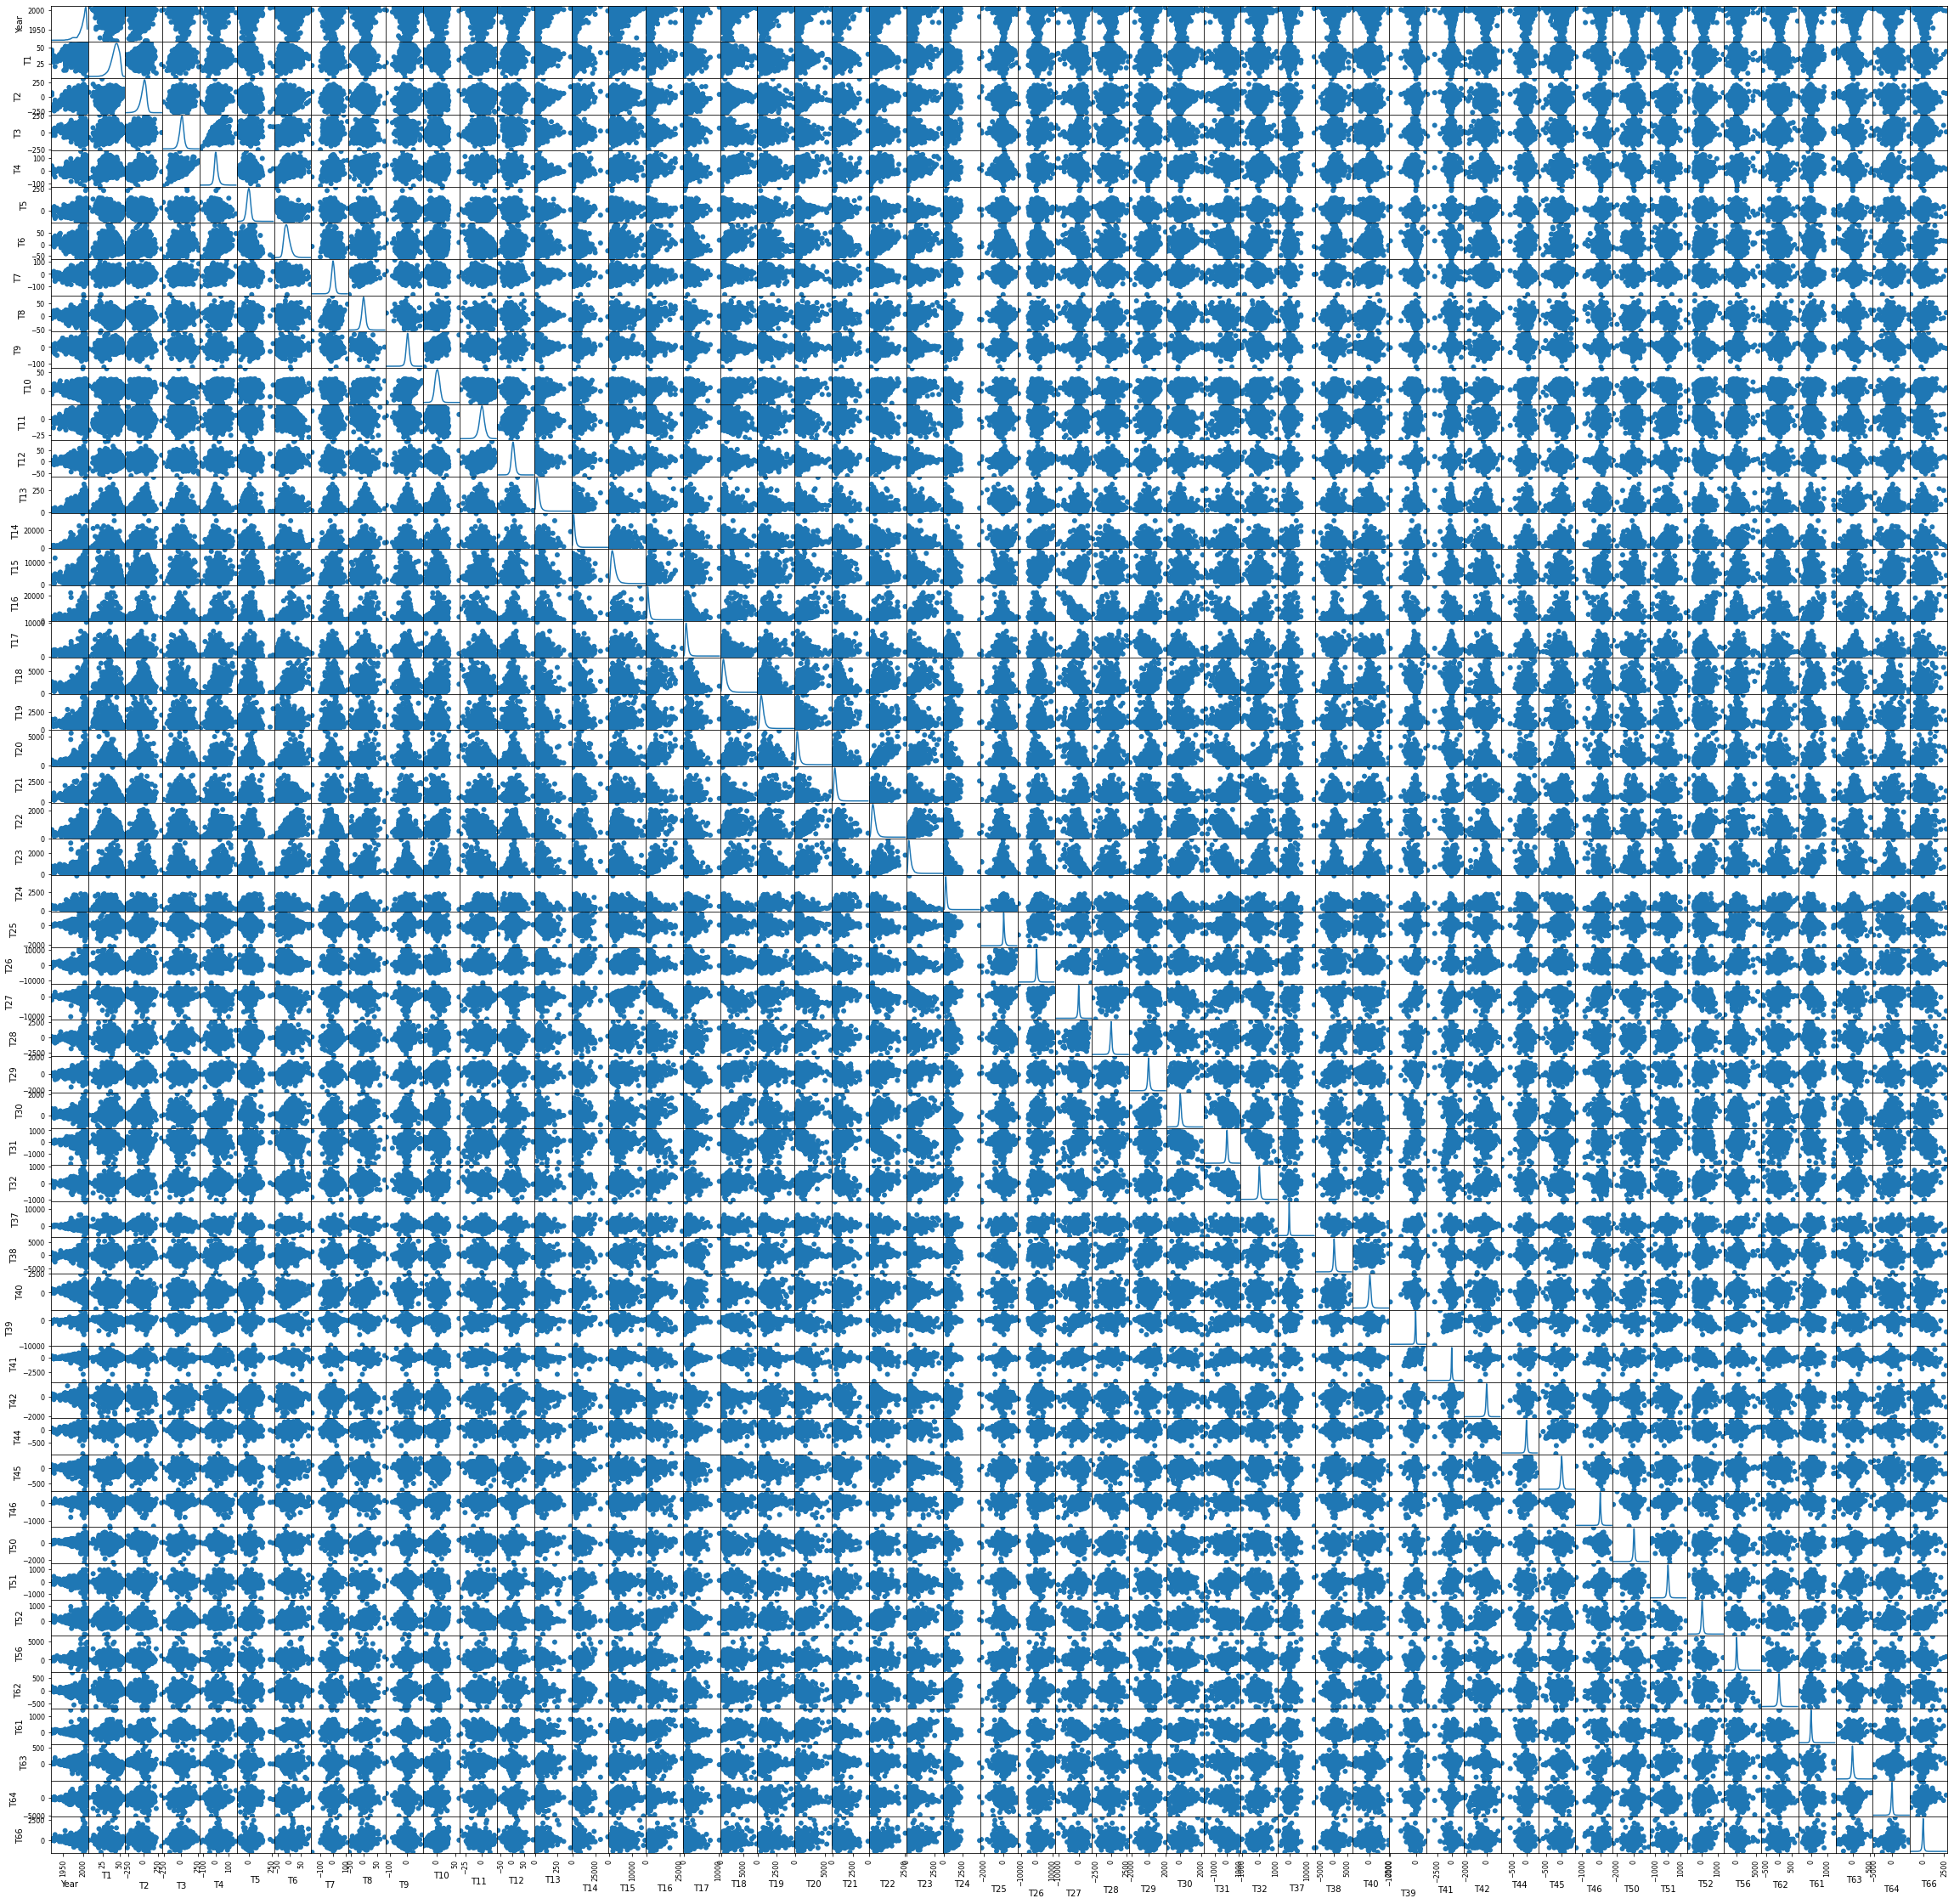

In [18]:
# scatter plot 
scatter_matrix(df_sel, alpha=1, figsize=(40, 40), diagonal='kde', marker="o")

# Prepare Data for Training

In [20]:
X = df_sel.iloc[:,1:].to_numpy()  # selected columns of attributes
Y = df_sel.iloc[:,0].to_numpy()   # "Year" column

## normalize 

In [21]:
# min/max method, values between 0 and 1
a = X.min()
b = X.max()
X = (X - a) / (b - a)  
Y = Y - Y.min()       

Keras Model


In [22]:
# Training data set
X_train = X[0:463715]
y_train = Y[0:463715]

# Validation data set
X_test = X[463715:]
y_test = Y[463715:]

In [30]:
Y_train = np_utils.to_categorical(y_train, year_range)
Y_test = np_utils.to_categorical(y_test, year_range)